## Coding Exercise #0808

In [1]:
#To enable CPU execution only
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
# Available backend options are: "jax", "tensorflow", "torch".
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

#### 1. Document classification with LSTM + CNN network (Binary):

In [3]:
import time
import pandas as pd
import numpy as np
import warnings    
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets.imdb import load_data, get_word_index       # Movie review data. 
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Embedding, Conv1D, MaxPool1D, Dropout
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.optimizers import Adam, RMSprop, SGD
warnings.filterwarnings('ignore')                              # Turn the warnings off.
%matplotlib inline

#### 1.1. Read in the data:

In [4]:
n_words = 3000                                        # Size of the vocabulary.
(X_train, y_train), (X_test, y_test) = load_data(num_words = n_words)
n_train_size = X_train.shape[0]

In [5]:
# Check for the shapes.
print("-"*50)
print("Training data X shape: {}".format(X_train.shape))
print("Training data y shape: {}".format(y_train.shape))
print("-"*50)
print("Test data X shape: {}".format(X_test.shape))
print("Test data y shape: {}".format(y_test.shape))
print("-"*50)

--------------------------------------------------
Training data X shape: (25000,)
Training data y shape: (25000,)
--------------------------------------------------
Test data X shape: (25000,)
Test data y shape: (25000,)
--------------------------------------------------


#### 1.2. Explore the data:

In [6]:
# Number of unique values of y = Number of categories of the newswires.
n_cat = pd.Series(y_train).nunique()
n_cat

2

In [7]:
# Print out an observation (document) contained in X.
# It is encoded as integers (indices).
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [8]:
# Let's check for length of the first 100 documents.
# We notice that the length is not uniform.
print([len(a) for a in X_train[0:100]])

[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129, 140, 256, 888, 93, 142, 220, 193, 171, 221, 174, 647, 233, 162, 597, 234, 51, 336, 139, 231, 704, 142, 861, 132, 122, 570, 55, 214, 103, 186, 113, 169, 469, 138, 302, 766, 351, 146, 59, 206, 107, 152, 186, 431, 147, 684, 383, 324, 252, 263, 787, 211, 314, 118, 390, 132, 710, 306, 167, 115, 95, 158, 156, 82, 502, 314, 190, 174, 60, 145, 214, 659, 408, 515, 461, 202, 238, 170, 107, 171]


In [9]:
# Download the dictionary to translate the indices.
my_dict = get_word_index(path='imdb_word_index.json')

In [10]:
# To view the dictionary.
# my_dict

In [11]:
# Exchange the 'key' and 'value'.
my_dict_inv = {v:k for k,v in my_dict.items()}

In [12]:
# Translate each document.
i_review = 10                                        # Document number that can be changed at will.
review = list(pd.Series(X_train[i_review]).apply(lambda x: my_dict_inv[x]))
print(' '.join(review))

the clear fact entertaining there life back br is and show of performance stars br actors film him many should movie reasons to and reading and are in of scenes and and of and out compared not boss yes to and show its disappointed fact raw to it justice by br of where clear fact many your way and with city nice are is along wrong not as it way she but this anything up haven't been by who of choices br of you to as this i'd it and who of shot you'll to love for and of you it is sequels of little quest are seen watched front chemistry to simply alive of chris being it is say easy and cry in chemistry but and all it maybe this is wing film job live of and relief and level names and and to be and serial and watch is men go this of wing american from and moving is and put this of jerry for places so work and watch and lot br that from sometimes and make department introduced to and from action at turns in low that in gay i'm of chemistry and i i simply alive it is time done inspector to wat

#### 1.3. Data preprocessing:

In [13]:
# Padding: newswire lengths are uniformly matched to maxlen.
# Cut away if longer than maxlen and fill with 0s if shorter than maxlen.
X_train = sequence.pad_sequences(X_train, maxlen = 100)
X_test = sequence.pad_sequences(X_test, maxlen = 100)

In [14]:
# y is already binary. Thus, there is no need to covert to the one-hot-encoding scheme.

#### 1.4. Define the model:

In [15]:
drop_prob = 0.5                   # Dropout probability. 
n_filters = 64                    # Number of filters (kernels).
k_size = 4                        # Kernel (filter) size.
stride_size = 1                   # Stride.
n_neurons = 50                    # Neurons within each memory cell.
n_input = 100                     # Dimension of the embeding space. 

In [16]:
# LSTM + CNN model..
my_model = Sequential()
my_model.add(Embedding(n_words,n_input))           # n_words = vocabulary size, n_input = dimension of the embedding space.
my_model.add(Dropout(rate=drop_prob))
my_model.add(Conv1D(filters=n_filters, kernel_size = k_size, strides=stride_size,padding='valid',activation='relu'))
my_model.add(MaxPool1D(pool_size = 2))
my_model.add(LSTM(units=n_neurons, return_sequences=False, input_shape=(None, n_input), activation='tanh'))
my_model.add(Dense(1, activation='sigmoid'))

2024-06-13 17:31:26.183342: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [17]:
# View the summary.
my_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### 1.5. Define the optimizer and compile:

In [18]:
n_epochs = 5                      # Number of epochs.
batch_size = 50                    # Size of each batch.
learn_rate = 0.002                 # learning rate.  

In [19]:
# Optimizer and compilation.
my_optimizer=Adam(learning_rate=learn_rate)
my_model.compile(loss = "binary_crossentropy", optimizer = my_optimizer, metrics=["accuracy"])

#### 1.6. Train the model and visualize the history:

In [21]:
my_summary = my_model.fit(X_train, y_train, epochs=n_epochs, batch_size = batch_size, validation_split=0.2, verbose = 0)

49.1730272769928


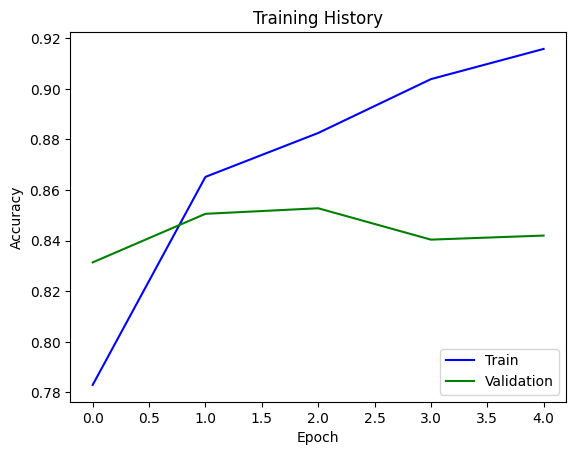

In [22]:
plt.plot(my_summary.history['accuracy'], c="b")
plt.plot(my_summary.history['val_accuracy'], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#### 1.7. Testing: 

In [23]:
ACC = my_model.evaluate(X_test, y_test, verbose=0)[1]    
print("Test Accuracy : {}".format(np.round(ACC,3)))

Test Accuracy : 0.842
